In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [ ]:
user=
password=
host=
db_name="consumption_project"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{db_name}")

In [ ]:
file_name='12월 지출 내역(25).csv'
df=pd.read_csv(file_name, encoding='utf-8-sig')

In [ ]:
unique_category=pd.DataFrame({'category_name': df['category'].unique()})

In [ ]:
unique_category.to_sql('category', con=engine, if_exists='append', index=False)

10

In [ ]:
category_db=pd.read_sql("select*from category", engine)
category_map=dict(zip(category_db['category_name'], category_db['category_id']))

In [ ]:
df['category_id']=df['category'].map(category_map)
df_final=df[['date', 'amount', 'category_id', 'text']]

In [ ]:
df_final = pd.DataFrame({
    'expenditure_date': df['date'],
    'expenditure_amount': df['amount'],
    'expenditure_category': df['category'].map(category_map),
    'expenditure_text': df['text']
})
df_final.to_sql('expenditure', con=engine, if_exists='append', index=False)

31

In [ ]:
print(pd.read_sql("DESC category", engine))

           Field         Type Null  Key Default           Extra
0    category_id          int   NO  PRI    None  auto_increment
1  category_name  varchar(30)   NO         None                


In [ ]:
print(pd.read_sql("DESC expenditure", engine))

                  Field         Type Null  Key Default           Extra
0        expenditure_id          int   NO  PRI    None  auto_increment
1      expenditure_date         date   NO         None                
2    expenditure_amount          int   NO         None                
3  expenditure_category  varchar(30)   NO         None                
4      expenditure_text         text  YES         None                


In [ ]:
print(pd.read_sql("DESC category", engine))

           Field         Type Null  Key Default           Extra
0    category_id          int   NO  PRI    None  auto_increment
1  category_name  varchar(30)   NO         None                


In [ ]:
query = """
SELECT c.category_name, SUM(e.expenditure_amount) as total_amount
FROM expenditure e
JOIN category c ON e.expenditure_category = c.category_id
GROUP BY c.category_name;
"""

df_pie = pd.read_sql(query, engine)

In [ ]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

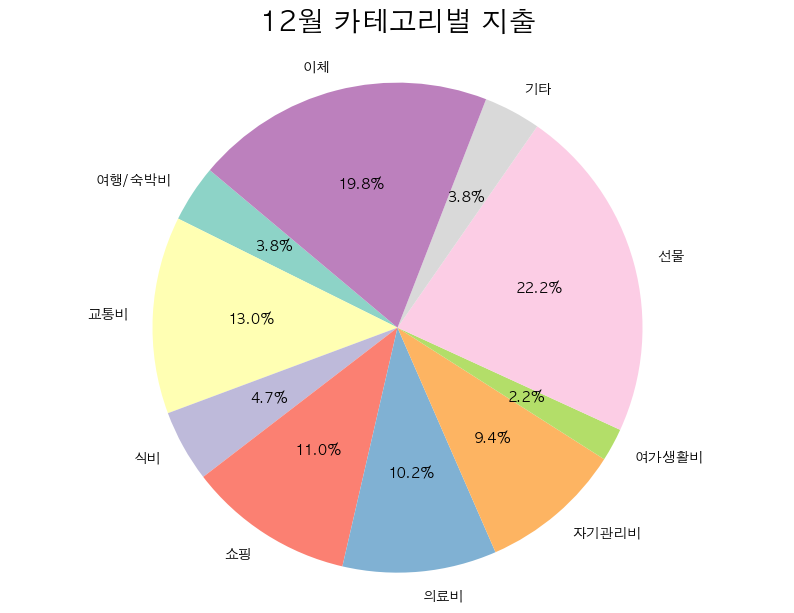

In [ ]:
plt.figure(figsize=(10, 7))
if not df_pie.empty:
    plt.pie(df_pie['total_amount'],
            labels=df_pie['category_name'],
            autopct='%1.1f%%',
            startangle=140,
            colors=plt.cm.Set3.colors)

    plt.title('12월 카테고리별 지출', fontsize=20, pad=20)
    plt.axis('equal')
    plt.show()
else:
    print("데이터를 삽입하세요.")

In [ ]:
query = """
SELECT DATE_FORMAT(expenditure_date, '%%Y-%%u주') as week, SUM(expenditure_amount) as total_amount
FROM expenditure
GROUP BY week
ORDER BY week;
"""
df_weekly = pd.read_sql(query, engine)

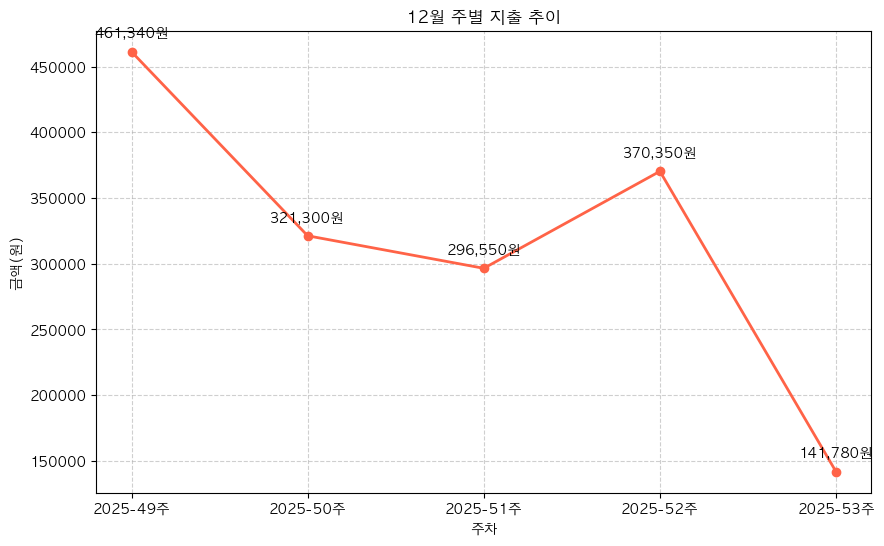

In [ ]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(10, 6))
plt.plot(df_weekly['week'], df_weekly['total_amount'], marker='o', color='tomato', linewidth=2)

plt.title('12월 주별 지출 추이')
plt.xlabel('주차')
plt.ylabel('금액(원)')
plt.grid(True, linestyle='--', alpha=0.6)

for i, txt in enumerate(df_weekly['total_amount']):
    plt.annotate(f'{int(txt):,}원', (df_weekly['week'][i], df_weekly['total_amount'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [ ]:
import calendar
query = "SELECT expenditure_date, SUM(expenditure_amount) as daily_total FROM expenditure GROUP BY expenditure_date"
df = pd.read_sql(query, engine)

In [ ]:
query = """
SELECT expenditure_date, SUM(expenditure_amount) as daily_total
FROM expenditure
WHERE expenditure_date BETWEEN '2025-12-01' AND '2025-12-31'
GROUP BY expenditure_date
ORDER BY expenditure_date;
"""
df = pd.read_sql(query, engine)

In [ ]:
df['expenditure_date'] = pd.to_datetime(df['expenditure_date'])
df['day'] = df['expenditure_date'].dt.day
df['weekday'] = df['expenditure_date'].dt.weekday

In [ ]:
all_days = pd.DataFrame({'day': range(1, 32)})
df_full = pd.merge(all_days, df, left_on='day', right_on='df.expenditure_date.dt.day' if False else 'day', how='left').fillna(0)

In [ ]:
first_weekday = calendar.monthrange(2025, 12)[0]

In [ ]:
def get_week_and_weekday(day):
    idx = day + first_weekday - 1
    return idx // 7, idx % 7

In [ ]:
import numpy as np
calendar_grid = np.zeros((6, 7))
day_labels = np.zeros((6, 7))

In [ ]:
for d in range(1, 32):
    week, wday = get_week_and_weekday(d)
    amount = df_full[df_full['day'] == d]['daily_total'].values[0]
    calendar_grid[week, wday] = amount
    day_labels[week, wday] = d

In [ ]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

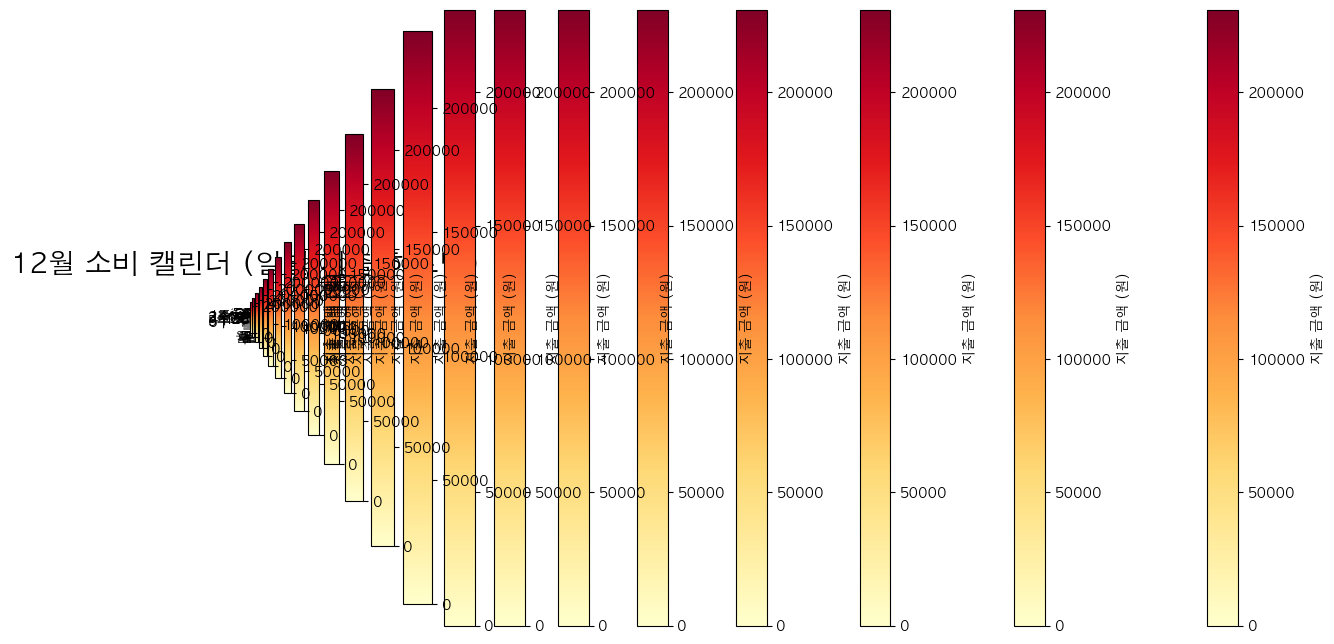

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(calendar_grid, cmap='YlOrRd')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
ax.set_yticks(np.arange(6))
ax.set_yticklabels([f'{i+1}주' for i in range(6)])
for i in range(6):
    for j in range(7):
        day_num = int(day_labels[i, j])
        if day_num > 0:
            ax.text(j-0.4, i-0.3, str(day_num), va='top', ha='left', fontsize=10, color='gray')
            amount = calendar_grid[i, j]
            if amount > 0:
                ax.text(j, i, f'{int(amount/1000)}k', ha='center', va='center',
                        color='black' if amount < calendar_grid.max()*0.7 else 'white',
                        fontweight='bold')
                plt.colorbar(im, label='지출 금액 (원)', shrink=0.8)
plt.title('12월 소비 캘린더 (일별 지출 히트맵)', fontsize=20, pad=30)
plt.tight_layout()
plt.show()

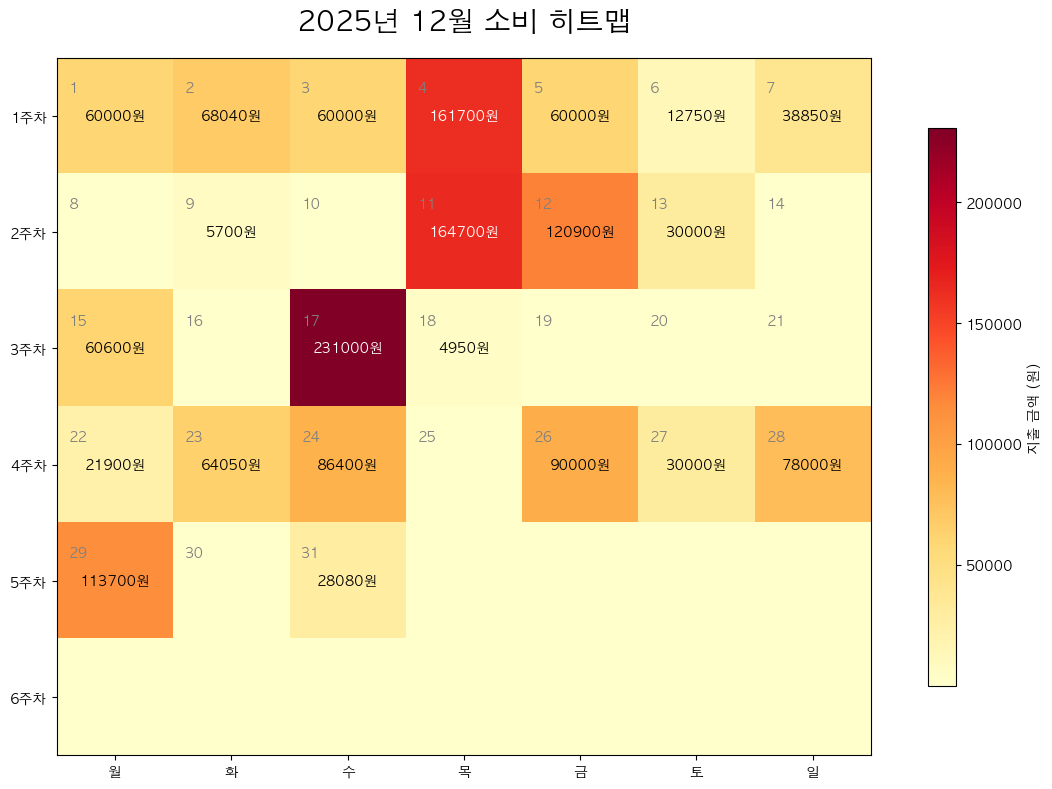

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar

year, month = 2025, 12
first_weekday = 0

calendar_grid = np.zeros((6, 7))
day_labels = np.zeros((6, 7))

for d in range(1, 32):
    day_data = df_full[df_full['day'] == d]
    amount = day_data['daily_total'].values[0] if not day_data.empty else 0

    idx = d + first_weekday - 1
    row = idx // 7
    col = idx % 7

    if row < 6:
        calendar_grid[row, col] = amount
        day_labels[row, col] = d

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(calendar_grid, cmap='YlOrRd', vmin=1, aspect='equal')

ax.set_xticks(np.arange(7))
ax.set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
ax.set_yticks(np.arange(6))
ax.set_yticklabels([f'{i+1}주차' for i in range(6)])

for i in range(6):
    for j in range(7):
        day_num = int(day_labels[i, j])
        if day_num > 0:
            ax.text(j-0.4, i-0.3, str(day_num), va='top', ha='left', fontsize=10, color='gray')
            amount = calendar_grid[i, j]
            if amount > 0:
                color = 'white' if amount > calendar_grid.max() * 0.6 else 'black'
                ax.text(j, i, f'{int(amount)}원', ha='center', va='center', fontweight='bold', color=color)

plt.colorbar(im, label='지출 금액 (원)', shrink=0.8)
plt.title('2025년 12월 소비 히트맵', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
target_budget = 400000

In [ ]:
query = "SELECT SUM(expenditure_amount) as total FROM expenditure"
df_total = pd.read_sql(query, engine)
current_spend = df_total['total'].iloc[0] if df_total['total'].iloc[0] else 0

In [ ]:
query = "SELECT SUM(expenditure_amount) as total FROM expenditure"
df_total = pd.read_sql(query, engine)
current_spend = df_total['total'].iloc[0] if df_total['total'].iloc[0] else 0

In [ ]:
remaining_budget = target_budget - current_spend
spend_ratio = (current_spend / target_budget) * 100

In [ ]:
print(f"--- 12월 소비 리포트 ---")
print(f" 목표 예산: {target_budget:,}원")
print(f" 현재 지출: {int(current_spend):,}원")
print(f" 남은 금액: {int(remaining_budget):,}원")
print(f" 예산 대비: {spend_ratio:.1f}% 사용")

--- 12월 소비 리포트 ---
 목표 예산: 400,000원
 현재 지출: 1,591,320원
 남은 금액: -1,191,320원
 예산 대비: 397.8% 사용


In [ ]:
from sqlalchemy import text # 이 부분을 불러와야 합니다.

with engine.connect() as conn:
    # 문자열을 text()로 감싸서 실행합니다.
    conn.execute(text("TRUNCATE TABLE expenditure;"))
    conn.commit()

print("✅ 지출 내역이 깨끗하게 비워졌습니다. 이제 데이터를 한 번만 다시 넣어보세요!")

✅ 지출 내역이 깨끗하게 비워졌습니다. 이제 데이터를 한 번만 다시 넣어보세요!


In [ ]:
df = pd.read_csv('12월 지출 내역(25).csv', encoding='utf-8-sig')
df_final = pd.DataFrame({
    'expenditure_date': df['date'],
    'expenditure_amount': df['amount'],
    'expenditure_category': df['category'].map(category_map),
    'expenditure_text': df['text']
})
df_final.to_sql('expenditure', con=engine, if_exists='append', index=False)

31

In [ ]:
target_budget = 400000

In [ ]:
query = "SELECT SUM(expenditure_amount) as total FROM expenditure"
df_total = pd.read_sql(query, engine)
current_spend = df_total['total'].iloc[0] if df_total['total'].iloc[0] else 0

In [ ]:
query = "SELECT SUM(expenditure_amount) as total FROM expenditure"
df_total = pd.read_sql(query, engine)
current_spend = df_total['total'].iloc[0] if df_total['total'].iloc[0] else 0

In [ ]:
remaining_budget = target_budget - current_spend
spend_ratio = (current_spend / target_budget) * 100
over_ratio = spend_ratio - 100

In [ ]:
print(f"--- 12월 소비 리포트 ---")
print(f" 목표 예산: {target_budget:,}원")
print(f" 현재 지출: {int(current_spend):,}원")
print(f" 남은 금액: {int(remaining_budget):,}원")
print(f" 초과 지출: {over_ratio:.2f}%")

--- 12월 소비 리포트 ---
 목표 예산: 400,000원
 현재 지출: 530,440원
 남은 금액: -130,440원
 초과 지출: 32.61%
